# Part 4. Model-based analysis

In the previous part, we pre-processed the fmri data, we fit the behavioral model, and extracted signal from each participant's striatum. Now, we're ready to do the final step: the model-based analysis, to see if differences in signal in striatum due to a `speed` cue versus an `accuracy` cue correlate with threshold differences.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nilearn
import seaborn as sns
import pandas as pd
import scipy as sp
from scipy import stats

import glob
import re
%matplotlib inline

We start out by loading all extracted striatum signal of all participants. Using the following line of code, you can make a list of all `.txt`-files that were generated before.

In [3]:
fns = glob.glob('/data/extracted_signals/extracted_timeseries/_mask_*_subject_id_*/_extract*/*.txt')
fns[:10]

['/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_381/_extract_mean_ts0/sub-381_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_381/_extract_mean_ts1/sub-381_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_549/_extract_mean_ts0/sub-549_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_549/_extract_mean_ts1/sub-549_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_559/_extract_mean_ts0/sub-559_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_559/_extract_mean_ts1/sub-559_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_t

Each of the file names contains the subject id, the applied mask, and the run/block number. We later want to extract these, and for this we can use a regular expression. It's a bit of an 'art' to create these, but you want something like this:

In [4]:
reg = re.compile('.*/_mask_(?P<mask_name>.*)_subject_id_(?P<subj_idx>.*)/_extract_mean_ts[0-9]/sub-[0-9]*_task-SAT_run-(?P<block>[0-9])_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt')

To visualize what reg does, you can do the following:

In [5]:
for fn in fns[:5]:
    print(fn)
    print(reg.match(fn).groupdict())

/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_381/_extract_mean_ts0/sub-381_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_R', 'subj_idx': '381', 'block': '1'}
/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_381/_extract_mean_ts1/sub-381_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_R', 'subj_idx': '381', 'block': '2'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_549/_extract_mean_ts0/sub-549_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_L', 'subj_idx': '549', 'block': '1'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_549/_extract_mean_ts1/sub-549_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_L', 'subj_idx': '549', 'block': '2'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_559/_extract_mean_ts0/sub-559_task-SAT_run-1_space-M

1) What does the call `reg.match(fn).groupdict()` do?

*From every file path, it extracts the applied mask, the subject id, and the block number. We'll use this next.*

An especially useful library is [pandas](http://pandas.pydata.org/), which allows you to manipulate data in an `R`-like DataFrame. Next, I'll combine all neural data of all subjects in a single DataFrame.

In [6]:
# create an empty list first
df = []

# loop over .txt-files, adding signal row-by-row
for fn in fns:
    d = reg.match(fn).groupdict()  # here, we extract the paths
    d['signal'] = np.loadtxt(fn)
    df.append(d)

df = pd.DataFrame(df)  # here, we convert the list to a DataFrame
df['block'] = df['block'].astype(int)
df['subj_idx'] = df['subj_idx'].astype(int)

2) Have a look at the head of the dataframe, what do you see? Can you plot the signal for a few subjects?

In [7]:
df.head()

,mask_name,subj_idx,block,signal
0,STR_R,381,1,"[447.3622664, 447.7903752, 446.7620939, 447.12..."
1,STR_R,381,2,"[440.2781772, 439.6897098, 439.3496493, 439.98..."
2,STR_L,549,1,"[454.5345986, 454.9737079, 454.1015037, 454.68..."
3,STR_L,549,2,"[458.7845412, 458.2852573, 457.2784219, 457.14..."
4,STR_L,559,1,"[432.7153821, 432.6016562, 431.5527966, 431.93..."


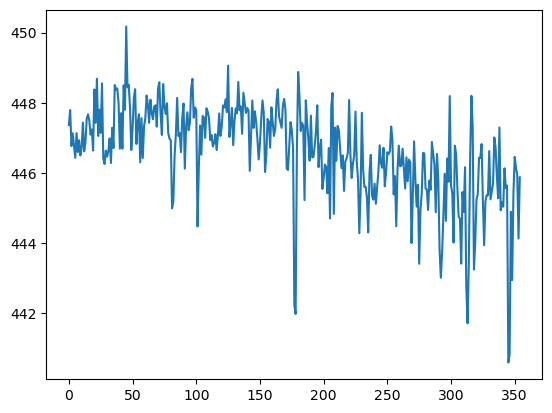

In [8]:
plt.plot(df.iloc[0]['signal'])

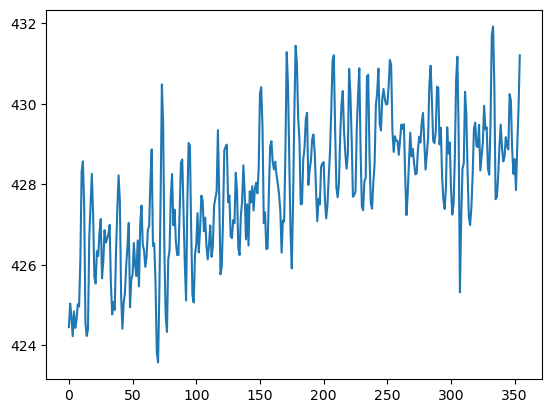

In [9]:
# alternatively, a bit obscure but you can index on the subj idx, block, and mask you're interested in
signal = df.loc[(df.subj_idx==551) & (df.block==1) & (df.mask_name=='STR_L'), 'signal'].iloc[0]
plt.plot(signal)

### A look at design matrices
Crucial to the GLM is the design matrix. The general idea is that you, as a researcher, specify when in the experiment each 'event' took place (i.e., each cue, stimulus, perhaps responses - anything that you think may elicit a BOLD response). Then, you convolve these events with the canonical hemodynamic response function. The result of this convolution is the _predicted_ timeseries.

`Nilearn` is a Python package that allows you to easily create a design matrix. Before turning to the actual experiment, let's make a dummy design matrix

In [10]:
# Import some functions
from nilearn import glm

In [11]:
# Suppose we create a dummy experiment with 2 conditions. Each condition occurs three times in the experiment
conditions = ['condition1'] * 3 + ['condition2'] * 3

# Then, we specify *when* (time in seconds from experiment onset, start counting at 0) events took place (collapse over conditions here)
onsets = [5, 25 , 35, 15, 30, 40]

# and let's assume all events took 1 second
duration = [1] * len(conditions)

# combine
events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                        'duration': duration})

# You need to know the TR of the scanning sequence
tr = 2.0

# Create a vector containing all the time points at which you have a volume (i.e. 'scan'/'image')
frame_times = np.arange(0, 50, tr)

# Define the type of hemodynamic response function (hrf) you want to use -- 'glover' is the 'canonical' one
hrf_model = 'glover'

# and now we can create the design matrix
X = glm.first_level.make_first_level_design_matrix(frame_times=frame_times, events=events, drift_model=None, hrf_model=hrf_model)

3) Have a look at the newly created variable X. What is its shape (how many columns & rows are there)? Also, can you plot X?

In [12]:
X.shape

(25, 3)

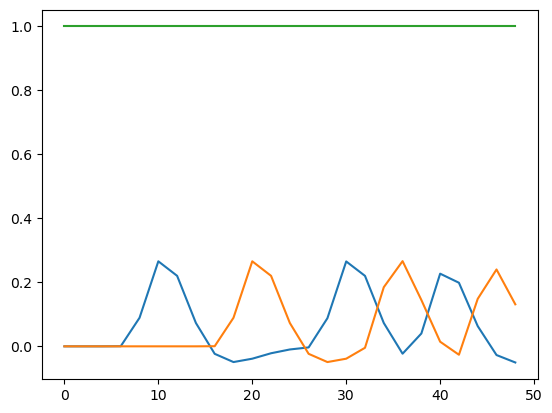

In [13]:
plt.plot(X)

The plot above is the design matrix: it contains an intercept (the line at y=1), and two predicted BOLD-responses, which we expect if we build an experiment that have events at the `onsets` specified above.

## Let's make the real design matrices
In BIDS-format, the information about the events in the experiment is always placed together with the BOLD-nifti. That is, you can find it here:

`/data/bids/sub-<subject_id>/func/sub-<subject_id>_task-SAT_run-<run_idx>_events.tsv'`  

(.tsv is a tab-separated file, very much like a csv)

Let's load the events of a single subject (let's take 548) and a single run/block (block 1)

In [14]:
subj_idx = 548
block = 1
mask = 'STR_L'

events = pd.read_csv('/data/bids/sub-%d/func/sub-%d_task-SAT_run-%d_events.tsv' %(subj_idx, subj_idx, block), sep='\t')
events = events[pd.notnull(events.event_type)]  # remove null trials
events = events.rename(columns={'event_type': 'trial_type'}) # rename the 'event_type' column to 'trial_type', which nilearn expects

events.head()

,onset,duration,weight,trial_type
0,14.1916,2,1,speed
1,19.2006,2,1,stimleft
2,28.1941,2,1,speed
3,42.1966,2,1,acc
4,46.2096,2,1,stimleft


`events` is now a DataFrame with four columns: onset (when in the experiment the event started), duration, weight (you can forget about this for this experiment, but this is what you would adjust if you have a parametric design), and event_type.

There are 4 event types in this run: a speed cue, an acc(uracy) cue, stimulus left, stimulus right. All events took 2 seconds. Now, turning this into a design matrix...

In [15]:
tr = 1.994
frame_times = np.arange(0, 706, tr)
hrf_model = 'glover'

X = glm.first_level.make_first_level_design_matrix(frame_times=frame_times, events=events, drift_model=None, hrf_model=hrf_model)

/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column 'weight' in events data. It will be ignored.
  warnings.warn(


Again, plot X. What are the 'conditions' here, and what are the 'onsets'?

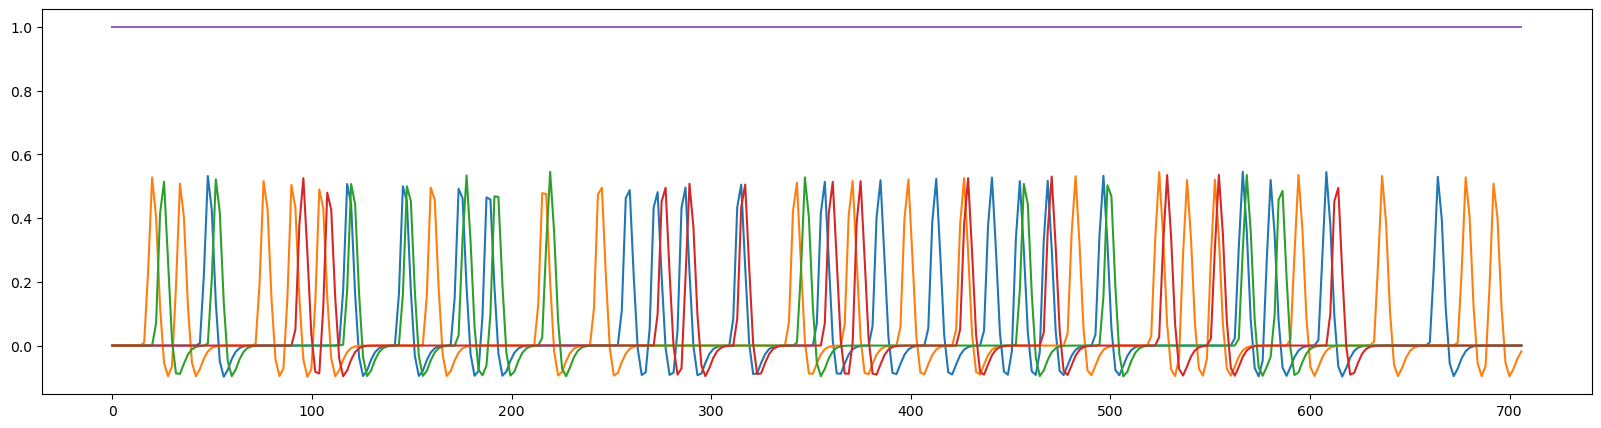

In [16]:
plt.plot(X)

plt.gcf().set_size_inches((20, 5))

X is what we _expect_ a voxel does _if_ it responds to the defined events. Now, in order to assess whether or not striatum responds to these events, we fit the data to our GLM, as follows:

In [17]:
import statsmodels.api as sm
Y = df[(df.subj_idx == subj_idx) & (df.block == block) & (df.mask_name == mask)].iloc[0].signal
model = sm.OLS(Y, X)
r = model.fit()
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     7.749
Date:                Thu, 20 Jul 2023   Prob (F-statistic):           5.42e-06
Time:                        12:09:32   Log-Likelihood:                -481.86
No. Observations:                 355   AIC:                             973.7
Df Residuals:                     350   BIC:                             993.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
acc           -0.1331      0.321     -0.415      0.679      -0.764       0.498
speed          1.2713      0.317      4.016      0.000       0.649       1.894
stimleft       1.2727      0.397      3.202      0.001       0.491       2.054
stimright      1.0049      0.396      2.537      0.012       0.226       1.784
constant     433.2235      0.060   7255.724      0.000     433.106     433.341
==============================================================================
Omnibus:                        2.832   Durbin-Watson:                   1.047
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                2.827
Skew:                           0.100   Prob(JB):                        0.243
Kurtosis:                       3.389   Cond. No.                         8.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5) Interpret these results

*Especially interesting are the coefficients and corresponding standard errors, t-values, and p-values. These indicate how large the BOLD-response was after each of the event types. For this subject and block, it seems that the speed condition activated striatum, but not the accuracy condition. (Did you expect this?)*

*Note also that the variance explained by the model is not a lot ($R^2$ is 0.101), which is quite typical for fMRI studies. We can also plot the quality of the fit to visualize this*

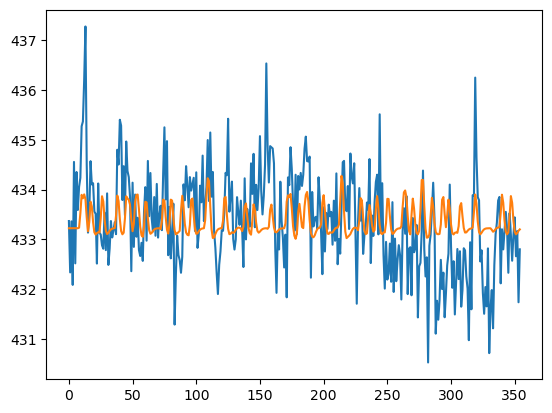

In [18]:
plt.plot(Y)
plt.plot(model.predict(r.params))

Now, we want to fit the GLM for all participants & blocks & masks. In the following function, we create the design matrix for each subject/mask/block, and fit the GLM.

6) Create a function that receives the subj_idx, block, and mask as arguments, and returns the beta-values of a fitted glm. (Most of this is copying the previous cells)

In [19]:
def fit_glm(subj_idx, block, mask):
    
    events = pd.read_csv('/data/bids/sub-%d/func/sub-%d_task-SAT_run-%d_events.tsv' %(subj_idx, subj_idx, block), sep='\t')
    events = events[pd.notnull(events.event_type)]  # remove null trials    
    events = events[(events.event_type == 'speed') | (events.event_type == 'acc')]  # remove null trials
    events = events.rename(columns={'event_type': 'trial_type'})
    del events['weight']  # not used
    
    # print(events)
    Y = df[(df.subj_idx == subj_idx) & (df.block == block) & (df.mask_name == mask)].iloc[0].signal
    
    tr = 1.994
    frame_times = np.arange(0, len(Y)*tr, tr)
    hrf_model = 'glover'

    X = glm.first_level.make_first_level_design_matrix(frame_times=frame_times, events=events, drift_model=None, hrf_model=hrf_model)
    
    model = sm.OLS(Y, X)
    r = model.fit()
    
    return r.params

If your function is correct, running the following cell should give the beta values for acc (-0.309878), speed (0.905169), and a constant (418.579979)

In [20]:
fit_glm(548, 1, 'STR_R')

acc          -0.309878
speed         0.905169
constant    418.579979
dtype: float64

In [21]:
results = []

for fn in fns:
    subj_idx = int(reg.match(fn).groupdict()['subj_idx'])
    block = int(reg.match(fn).groupdict()['block'])
    for mask in ['STR_L', 'STR_R']:
        r = fit_glm(subj_idx, block, mask)
        
        for condition in ['acc', 'speed']:
            d = {}
            d['subj_idx'] = subj_idx
            d['mask_name'] = mask
            d['block'] = block
            d['condition'] = condition
            d['value'] = r[condition]
            results.append(d)

results = pd.DataFrame(results)

Have a look at the `results` DataFrame. 

In [22]:
results

,subj_idx,mask_name,block,condition,value
0,381,STR_L,1,acc,0.574214
1,381,STR_L,1,speed,0.119136
2,381,STR_R,1,acc,-0.984312
3,381,STR_R,1,speed,-0.396816
4,381,STR_L,2,acc,0.131713
...,...,...,...,...,...
267,555,STR_R,1,speed,0.049481
268,555,STR_L,2,acc,-0.047353
269,555,STR_L,2,speed,-0.180979
270,555,STR_R,2,acc,-0.117430


Alright, in the above cells we fitted a GLM for each subject & block & mask combination. Next, we want to combine these results with the behavioral results. In order to do this, it's useful to first transform the shape of the data frame a little bit.

In [23]:
neural_results = results.pivot_table(values='value', columns=['condition', 'mask_name'], index=['subj_idx'])
neural_results.columns = ['_'.join(col).strip() for col in neural_results.columns.values]
neural_results

,acc_STR_L,acc_STR_R,speed_STR_L,speed_STR_R
subj_idx,,,,
197,0.403354,0.490836,1.044504,0.879156
372,0.760775,0.736704,1.473652,1.221147
381,0.352964,-0.394016,0.361246,0.241108
471,0.314304,0.398968,0.398408,0.187350
483,0.396738,0.206922,1.999833,1.552417
498,0.610133,0.801465,0.603117,-0.017342
523,0.028020,-0.130357,0.454041,0.404849
544,1.037709,1.295384,1.643617,1.907930
548,0.358907,0.143644,0.702766,0.237785


7) What did the cell above do?

The dataframe was reshaped and now has subject idx as index, and each cell contains a beta parameter for a mask/cue-combination. Further note that the information of the two blocks was meaned for each subject & mask.

Now we need to load the behavioral parameters

In [25]:
behavioral_results = pd.read_csv('/data/behavior_fits/parameters_per_subject_lba_B_emc_group.csv', index_col=0)
behavioral_results.rename(columns={'subjects': 'subj_idx'}, inplace=True)

## Get only threshold
behavioral_results = behavioral_results.set_index('subj_idx')
behavioral_results

behavioral_results['response_caution_diff'] = behavioral_results['B_acc']-behavioral_results['B_spd']
behavioral_results

,v_TRUE,v_FALSE,B_acc,B_spd,A,t0,response_caution_diff
subj_idx,,,,,,,
197,3.557803,1.369049,0.955276,0.002617,1.003795,0.216023,0.952659
372,3.811266,1.142452,1.122259,0.002228,1.061098,0.236603,1.120031
381,2.761378,1.734586,0.343226,0.007284,1.465745,0.270613,0.335942
471,2.332425,1.635613,1.637903,0.001526,0.694690,0.255284,1.636377
483,2.862264,1.133885,0.912306,0.002740,0.991456,0.232894,0.909566
498,2.632773,1.570203,0.662480,0.003774,1.132863,0.252116,0.658706
523,3.229652,1.248153,0.935051,0.002674,1.112732,0.234965,0.932377
544,3.210357,1.117598,0.888775,0.002813,1.266538,0.234281,0.885962
548,2.580278,1.206538,0.825688,0.003028,0.950639,0.292244,0.822660


We can combine the behavioral & neural data as follows

In [26]:
combined_data = pd.merge(neural_results, behavioral_results, left_index=True, right_index=True)
combined_data

,acc_STR_L,acc_STR_R,speed_STR_L,speed_STR_R,v_TRUE,v_FALSE,B_acc,B_spd,A,t0,response_caution_diff
subj_idx,,,,,,,,,,,
197,0.403354,0.490836,1.044504,0.879156,3.557803,1.369049,0.955276,0.002617,1.003795,0.216023,0.952659
372,0.760775,0.736704,1.473652,1.221147,3.811266,1.142452,1.122259,0.002228,1.061098,0.236603,1.120031
381,0.352964,-0.394016,0.361246,0.241108,2.761378,1.734586,0.343226,0.007284,1.465745,0.270613,0.335942
471,0.314304,0.398968,0.398408,0.187350,2.332425,1.635613,1.637903,0.001526,0.694690,0.255284,1.636377
483,0.396738,0.206922,1.999833,1.552417,2.862264,1.133885,0.912306,0.002740,0.991456,0.232894,0.909566
498,0.610133,0.801465,0.603117,-0.017342,2.632773,1.570203,0.662480,0.003774,1.132863,0.252116,0.658706
523,0.028020,-0.130357,0.454041,0.404849,3.229652,1.248153,0.935051,0.002674,1.112732,0.234965,0.932377
544,1.037709,1.295384,1.643617,1.907930,3.210357,1.117598,0.888775,0.002813,1.266538,0.234281,0.885962
548,0.358907,0.143644,0.702766,0.237785,2.580278,1.206538,0.825688,0.003028,0.950639,0.292244,0.822660


8) Can you plot the a scatterplot with:
- on the x-axis the difference between threshold in accuracy and speed trials? (acc - speed)
- on the y-axis the difference in striatum activation after an accuracy cue and a speed cue (acc - speed);

Do this for left & right striatum separately.
One function you could use is seaborn's [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html)

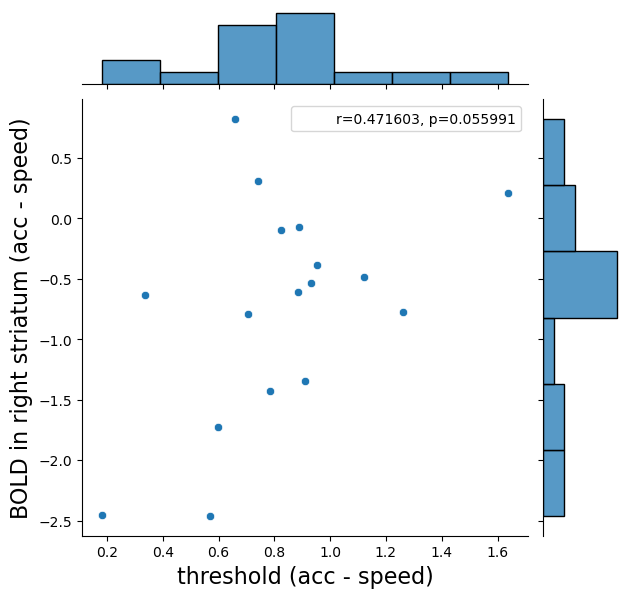

In [27]:
x = combined_data['response_caution_diff']
y = combined_data['acc_STR_R'] - combined_data['speed_STR_R']
j = sns.jointplot(x=x,y=y)


import scipy.stats as stats
j.set_axis_labels('threshold (acc - speed)', 'BOLD in right striatum (acc - speed)', fontsize=16)

r, p = stats.pearsonr(x, y)
# if you choose to write your own legend, then you should adjust the properties then
phantom, = j.ax_joint.plot([], [], linestyle="", alpha=0)
# here graph is not a ax but a joint grid, so we access the axis through ax_joint method

j.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

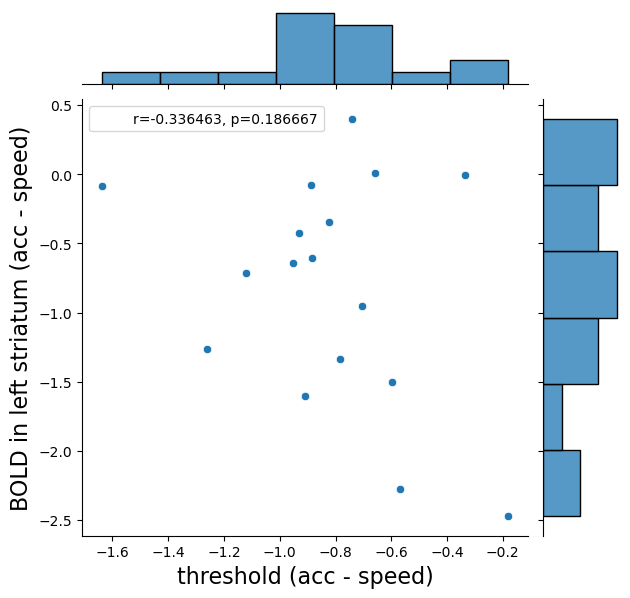

In [28]:
x = -combined_data['response_caution_diff']
y = combined_data['acc_STR_L'] - combined_data['speed_STR_L']
j = sns.jointplot(x=x,y=y)


import scipy.stats as stats
j.set_axis_labels('threshold (acc - speed)', 'BOLD in left striatum (acc - speed)', fontsize=16)

r, p = stats.pearsonr(x, y)
# if you choose to write your own legend, then you should adjust the properties then
phantom, = j.ax_joint.plot([], [], linestyle="", alpha=0)
# here graph is not a ax but a joint grid, so we access the axis through ax_joint method

j.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

What do you see? Is there a relation between striatal activation and threshold setting?

We don't seem to have replicated the Forstmann et al. 2008 results; although the right striatum suggests perhaps a non-significant effect due to a lack of power.

There's many ways to improve this analysis:

- I did not do a full model comparison of the behavioral data, which could imply that we're using an overfitted model and the parameter estimates are off. 
- It is better to use a hierarchical model combined with plausible values. 
- Or even better, a joint model where the neural and behavioral data are jointly modelled. 
- Further, I simplified the statistical modelling of the fMRI data for educative purposes; for example, in your first-level GLM, you want to pre-whiten the data, you want to temporally filter your data (get rid of the drift), and in the second level-analysis, potential variability in within-subject errors was ignored. Normally, you would want to use something like FSL's FEAT-algorithms such as FILMGLS and FLAME1/FLAME1+2 to do the statistical modelling.

But anyway, regardless, the above serves as an illustration of the general idea of traditional model-based analyses of fMRI data.

## You've reached the end